In [62]:
import copy
import string
import numpy as np
import pandas as pd
import pathlib as pl
import itertools as it
from typing import Callable
from functools import partial
from dataclasses import dataclass, field


WRITEOUT_OKAY = False

In [63]:

def train_test_split_indices(papers, test_size=0.2, rng=None) -> tuple[np.ndarray[int], np.ndarray[int]]:
    """
    Splits a list of papers into train and test indices.

    Parameters
    ----------
    papers : iterable of papers with ids
        List or dict of papers to split.
    test_size : float, optional
        if < 1, proportion of papers to reserve for testing, by default 0.2
        if > 1, number of papers to reserve for testing
    rng : int, optional
        Random state for the random number generator, default uses numpy's random

    Returns
    -------
    train_indices : list of int
        List of indices for the training set.
    test_indices : list of int
        List of indices for the testing set.
    """
    n = papers if isinstance(papers, int) else len(papers)
    if test_size < 1:
        test_size = int(np.floor(test_size * n))  # number of papers in test
    if rng is None:
        rng = np.random.default_rng()  # setup rng
    elif isinstance(rng, int):
        rng = np.random.default_rng(rng)

    if isinstance(papers, int):
        indices = np.arange(n)  # generate indices
    elif isinstance(papers, dict):
        indices = [paper.idx for paper in papers.values()]  # grab indices from dict entries
    else:  # assume papers is a dict or mapping of papers with a .values() method
        indices = papers  # assume papers is a list of indices
    indices = np.asarray(indices)

    # shuffle and split
    rng.shuffle(indices)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return train_indices, test_indices

In [64]:
@dataclass
class Paper:
    idx: str  # Paper ID
    label: str  # Paper category/topic
    features: tuple[bool, ...] = ()  # binary features
    cited_by: list[str] = field(default_factory=list)  # IDs of papers that cite this paper
    citations: list[str] = field(default_factory=list)  # IDs of papers cited by this paper


papers = {}
missing = set()

# Load in training data
content = pd.read_csv("data/citeseer/citeseer.content", sep="\t", header=None, dtype=object)
citations = pd.read_csv("data/citeseer/citeseer.cites", sep="\t", header=None, dtype=object)

labels = set()  # set of unique labels

for paper in content.itertuples(index=False):  # create papers from data
    # if paper[-1] == 'IR':
    #     continue
    idx = paper[0]
    features = tuple([int(feature) for feature in paper[1:-1]])  # parse features
    papers[idx] = Paper(idx, paper[-1], features)  # create paper object
    labels.add(paper[-1])  # label is the last column. add to set of labels

for paper_idx, citation in citations.itertuples(index=False):
    try:  # parse citations
        if citation not in papers:
            missing.add(citation)  # if citation is missing, add to missing list
            continue
        papers[paper_idx].citations.append(citation)
    except KeyError:
        missing.add(paper_idx)  # if paper is missing, add to missing list

print(f"Loaded {len(papers)} papers and skipped {len(missing)} broken references.")

labels  # show labels set

Loaded 3312 papers and skipped 15 broken references.


{'AI', 'Agents', 'DB', 'HCI', 'IR', 'ML'}

In [65]:
# add cited_by (reverse connections) which can only be done after all papers are loaded
for paper in papers.values():
    paper.cited_by = [other.idx for other in papers.values() if paper.idx in other.citations]

all_papers = copy.deepcopy(papers)

In [66]:
def components_undirected(papers):

    components = []

    for idx, paper in papers.items():
        new_component = {idx}  # new set
        new_component.update(paper.citations)  # add its citations
        matching_sets = [c for c in components if c & new_component]  # find existing components with overlap
        new_component = new_component.union(*matching_sets)  # merge overlapping components
        for s in matching_sets:  # remove any old overlapping components
            components.remove(s)
        components.append(new_component)  # add our new component

    return components

In [67]:
components = sorted(components_undirected(papers), key=len, reverse=True)
largest = components[0]

print([len(c) for c in components])
print(f"Found {len(components)} components, the largest has {len(largest)} papers")

[2110, 18, 17, 15, 13, 12, 12, 11, 10, 10, 9, 9, 9, 9, 9, 8, 8, 8, 8, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [68]:
def writeout(papers, path_stem, train_idxs=None, test_idxs=None, metadata=''):
    if not WRITEOUT_OKAY:
        return
    path = pl.Path(path_stem)
    if path.is_dir():
        raise ValueError(f"{path} is a directory")
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path.with_suffix('.content'), 'w') as f:
        for paper in papers.values():
            features = [str(int(feature)) for feature in paper.features]
            features = '\t'.join(features)
            f.write(f"{paper.idx:s}\t{features}\t{paper.label:s}\n")
    with open(path.with_suffix('.cites'), 'w') as f:
        for paper in papers.values():
            for cite in paper.citations:
                f.write(f"{paper.idx:s}\t{cite:s}\n")
    if train_idxs is not None and test_idxs is not None:
        train_idxs = [str(idx) for idx in train_idxs]
        test_idxs = [str(idx) for idx in test_idxs]
        with open(path.with_suffix('.indices'), 'w') as f:
            f.write(f"training_indices {len(train_idxs)} \\n test_indices {len(test_idxs)}\t{metadata}\n")
            f.write(', '.join(train_idxs))
            f.write('\n' + ', '.join(test_idxs))


In [69]:
def remove_broken_citations(papers):
    removed = set()
    for paper in papers.values():
        to_remove = []
        for citation in paper.citations:
            if citation not in papers:
                removed.add(citation)
                to_remove.append(citation)
        for citation in to_remove:
            paper.citations.remove(citation)
        to_remove = []
        for citer in paper.cited_by:
            if citer not in papers:
                removed.add(citer)
                to_remove.append(citer)
        for citer in to_remove:
            paper.cited_by.remove(citer)
    return removed


def rebuild(papers, ids):
    new_papers = {k: v for k, v in papers.items() if k in ids}
    removed_citations = remove_broken_citations(new_papers)
    return new_papers, removed_citations

In [70]:
def how_many(papers, train_idxs=None, do_print=True):
    def printif(*args, **kwargs):
        if do_print:
            print(*args, **kwargs)

    n_papers = len(papers)
    n_citations = sum([len(paper.citations) for paper in papers.values()])
    n_topics = len(set(paper.label for paper in papers.values()))
    printif(f"Papers: {n_papers}, Citations: {n_citations}, Topics: {n_topics}")
    neurons = n_papers + n_topics
    if train_idxs is None:
        printif(f"NEST-like implementation will use {neurons} neurons")
        return n_papers, n_citations, n_topics, neurons, None, None, None
    else:
        n_train, n_test = len(train_idxs), n_papers - len(train_idxs)
        synapses = n_citations * 2 + n_test * n_topics * 2 + n_train * 2
        printif(f"NEST-like implementation will use {neurons} neurons, {synapses} synapses")
        # printif(f"K implementation will use {n_papers + n_topics} neurons, {n_citations + n_papers} synapses")
        printif(f"Train: {n_train}, Test: {n_test} ({n_train / n_papers:.2f}:{n_test / n_papers:.2f})")
        return n_papers, n_citations, n_topics, neurons, synapses, n_train, n_test


In [71]:
def spider_papers(
    papers: dict,
    max_n: int,
    seed: int | str | Paper | None = None,
    rng: np.random.Generator | int | None = None,
    callback: Callable[[Paper], Paper] | None = None,
    directed=False,
):
    """Create a new connected graph of papers"""

    if rng is None:
        rng = np.random.default_rng()  # setup rng
    elif isinstance(rng, int):
        rng = np.random.default_rng(rng)

    seed = rng.choice(list(papers)) if seed is None else seed
    new_papers: dict[str | int, Paper] = {}
    # A paper is terminal if all its citations are in new_papers
    terminals = set()

    def is_terminal(paper):
        if isinstance(paper, (str, int)):
            paper: Paper = new_papers[paper]
        if not paper.citations and not paper.cited_by:
            return True
        return all(c in new_papers for c in paper.citations) and all(c in new_papers for c in paper.cited_by)

    def add_paper(paper: str | int | Paper):
        if isinstance(paper, (str, int)):
            paper: Paper = papers[paper]
        paper = copy.deepcopy(paper)
        new_papers[paper.idx] = callback(paper) if callback else paper
        return new_papers[paper.idx]

    paper = add_paper(seed)
    if is_terminal(paper):
        return new_papers

    while len(new_papers) < max_n:
        pool = set(new_papers) - terminals
        if not pool:
            break
        paper = new_papers[rng.choice(list(pool))]
        if is_terminal(paper):
            terminals.add(paper.idx)
            continue
        candidates = set(paper.citations) | set(paper.cited_by) - terminals
        assert candidates
        new_paper = add_paper(rng.choice(list(candidates)))
        if is_terminal(new_paper):
            terminals.add(new_paper.idx)

    return new_papers


In [ ]:
def components_undirected_minus(papers, candidate_idx):

    components = []

    for idx, paper in papers.items():
        if idx == candidate_idx:
            continue
        new_component = {idx}  # new set
        citations = [cite for cite in paper.citations if cite != candidate_idx]
        new_component.update(citations)  # add its citations
        matching_sets = [c for c in components if c & new_component]  # find existing components with overlap
        new_component = new_component.union(*matching_sets)  # merge overlapping components
        for s in matching_sets:  # remove any old overlapping components
            components.remove(s)
        components.append(new_component)  # add our new component
        assert candidate_idx not in new_component

    return components

def cull_papers(
    papers: dict,
    min_n: int,
    rng: np.random.Generator | int | None = None,
    callback: Callable[[Paper], Paper] | None = None,
):
    """Create a new connected subgraph of papers"""

    if rng is None:
        rng = np.random.default_rng()  # setup rng
    elif isinstance(rng, int):
        rng = np.random.default_rng(rng)

    new_papers = copy.deepcopy(papers)
    assert len(components_undirected(new_papers)) == 1

    candidates = list(new_papers)
    while len(new_papers) > min_n and candidates:
        # randomly select a paper
        paper = rng.choice(candidates)
        candidates.remove(paper)

        # check if conectivity is preserved by removing this paper
        components = components_undirected(new_papers, paper)
        if len(components) == 1:
            # if so, remove the paper
            new_papers.pop(paper)
            _removed = remove_broken_citations(new_papers)
            candidates = list(new_papers)


new_papers = cull_papers(miniseer, min_n=2100)

In [72]:
seed = 789879

# === Original dataset ===
train_idxs, test_idxs = train_test_split_indices(papers, test_size=0.8, rng=seed)
print("Original dataset:")
how_many(papers, train_idxs)

# === Miniseer ===
miniseer, removed = rebuild(papers, largest)
assert not removed
m_train_idxs, m_test_idxs = train_test_split_indices(miniseer, test_size=0.8, rng=seed)
writeout(miniseer, 'data/miniseer/miniseer', m_train_idxs, m_test_idxs, f"seed: {seed}")

print("\nMiniseer:")
how_many(miniseer, m_train_idxs)
minicomponents = sorted(components_undirected(miniseer), key=len, reverse=True)
minilargest = minicomponents[0]
print([len(c) for c in minicomponents])
print(f"Found {len(minicomponents)} components, the largest has {len(minilargest)} papers")

# === Microseer ===
microseer = spider_papers(miniseer, 84, seed='55740', rng=seed)
removed = remove_broken_citations(microseer)
u_train_idxs, u_test_idxs = train_test_split_indices(microseer, test_size=0.8, rng=seed)
writeout(microseer, 'data/microseer/microseer', u_train_idxs, u_test_idxs, f"seed: {seed}")
# STATS
print("\nMicroseer:")
how_many(microseer, u_train_idxs)
microcomponents = sorted(components_undirected(microseer), key=len, reverse=True)
microlargest = microcomponents[0]
print([len(c) for c in microcomponents])
print(f"Found {len(microcomponents)} components, the largest has {len(microlargest)} papers")
print(f"Removed {len(removed)} broken citations")

Original dataset:
Papers: 3312, Citations: 4715, Topics: 6
NEST-like implementation will use 3318 neurons, 42544 synapses
Train: 663, Test: 2649 (0.20:0.80)

Miniseer:
Papers: 2110, Citations: 3757, Topics: 6
NEST-like implementation will use 2116 neurons, 28614 synapses
Train: 422, Test: 1688 (0.20:0.80)
[2110]
Found 1 components, the largest has 2110 papers

Microseer:
Papers: 84, Citations: 132, Topics: 5
NEST-like implementation will use 89 neurons, 968 synapses
Train: 17, Test: 67 (0.20:0.80)
[84]
Found 1 components, the largest has 84 papers
Removed 218 broken citations


In [73]:
by_cited_cats = {}

for paper in miniseer.values():
    cite_categories = (set(papers[other].label for other in paper.citations) |
                       set(papers[other].label for other in paper.cited_by))
    by_cited_cats[paper.idx] = cite_categories

list(filter(lambda k: len(by_cited_cats[k]) >= 5, by_cited_cats))

['55740', 'craven98learning', 'horrocks98using']

In [74]:
def topics_counts(papers, labels=(), rekey=string.ascii_uppercase):
    if labels and isinstance(labels, str):
        labels = labels.split(' vs. ')
    if labels:
        rename_to = {label: letter for label, letter in zip(labels, rekey)}

    topics_count = {}
    for paper in papers.values():
        key = rename_to[paper.label] if labels else paper.label
        topics_count[key] = topics_count.get(key, 0) + 1
    return topics_count

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

categories = pd.DataFrame({
    'original': pd.Series(topics_counts(papers)),
    'miniseer': pd.Series(topics_counts(miniseer)),
    'microseer': pd.Series(topics_counts(microseer)),
}).T

categories

,AI,Agents,DB,HCI,IR,ML
original,249.0,596.0,701.0,508.0,668.0,590.0
miniseer,115.0,463.0,388.0,304.0,532.0,308.0
microseer,2.0,4.0,21.0,NaN,51.0,6.0


<Axes: xlabel='topic', ylabel='count'>

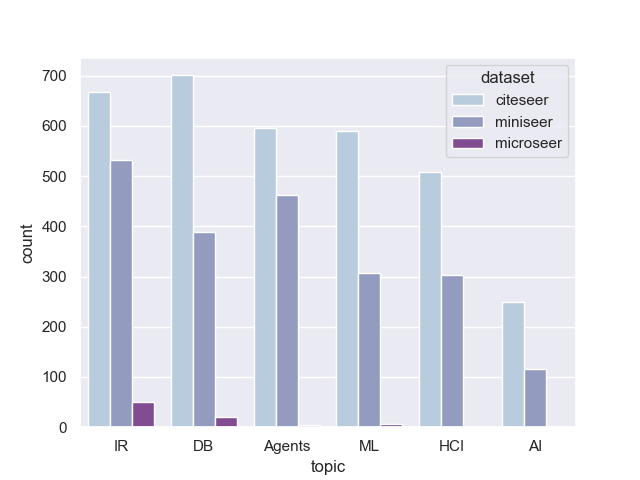

In [76]:
def todf(papers, name):
    df = pd.DataFrame([{'name': paper.idx, 'topic': paper.label, 'citations': len(paper.citations)} for paper in papers.values()])
    df['dataset'] = name
    return df


data = pd.concat([
    todf(papers, 'citeseer'),
    todf(miniseer, 'miniseer'),
    todf(microseer, 'microseer')])
sns.set_theme(style="darkgrid", palette=sns.color_palette(['#b3cde3', '#8c96c6', '#88419d']))
%matplotlib widget
fig, ax = plt.subplots()
index = data['topic'].value_counts().index
sns.countplot(data, x='topic', hue='dataset', order=index)

(0.0, 30.0)

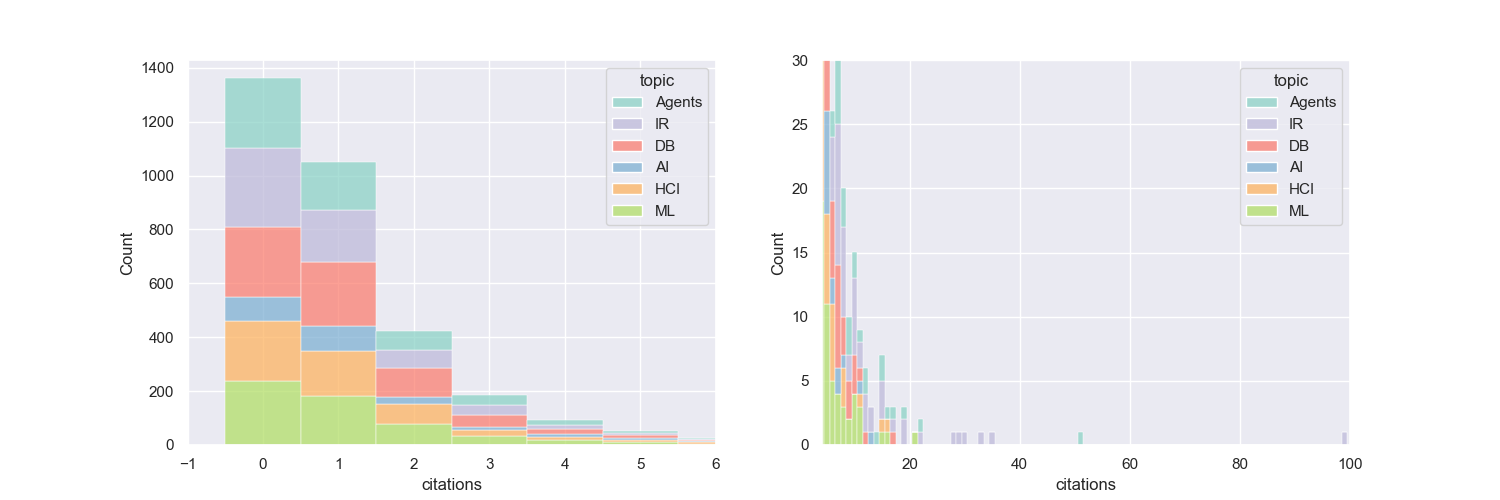

In [77]:
citeseer_df = todf(papers, 'citeseer')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_theme(style="darkgrid", palette=sns.color_palette(['#8dd3c7', '#bebada', '#fb8072', '#80b1d3', '#fdb462', '#b3de69']))
sns.histplot(
    citeseer_df, x='citations', hue='topic', ax=ax1,
    discrete=True,
    multiple='stack',
    # multiple='dodge',
    # log_scale=True,
)
# ax.set_xscale('log')
ax1.set_xlim(-1, 6)
sns.histplot(
    citeseer_df, x='citations', hue='topic', ax=ax2,
    discrete=True,
    multiple='stack',
    # multiple='dodge',
    # log_scale=True,
)
ax2.set_xlim(4, 100)
ax2.set_ylim(0, 30)

# BIteSEER

In [78]:
# def split_papers_by_labels(papers: dict, splits=None):
#     """Ensure a certain number of papers per label."""
#     # TODO: WIP
#     labels = set(paper.label for paper in papers.values())
#     by_label = {  # split dataset into groups of papers with the same label
#         label: [paper.idx for paper in papers.values() if paper.label == label]
#         for label in labels
#     }
#     if splits is None and labels:
#         splits = [1 / len(labels)] * len(labels)
#     if not isinstance(splits, dict):
#         splits = dict(zip(labels, splits))
#     if sum(splits.values()) <= 1:
#         splits = {k: int(v * )}

#     new = {}
#     for label, idxs in by_label.items():
#         new[label]


In [79]:
combos = list(it.combinations(labels, 2))
# print([' vs. '.join(pair) for pair in combos])

In [80]:
def filter_citations(paper: Paper, labels):
    paper.citations = [other for other in paper.citations if papers[other].label in labels]
    paper.cited_by = [other for other in paper.cited_by if papers[other].label in labels]
    return paper


bites = {}

for combo in combos:
    new_idxs = [paper.idx for paper in miniseer.values() if paper.label in combo]
    cited_cats = {paper_idx: set(papers[other].label for other in papers[paper_idx].citations) |
                             set(papers[other].label for other in papers[paper_idx].cited_by)
                             for paper_idx in new_idxs}
    candidate_seeds = list(filter(lambda k: set(combo) >= cited_cats[k], cited_cats))
    seed_paper = np.random.default_rng(seed).choice(candidate_seeds)
    bite = spider_papers(miniseer, 88, seed=seed_paper, rng=seed, callback=partial(filter_citations, labels=combo))
    _removed = remove_broken_citations(bite)
    new_train_idxs, new_test_idxs = train_test_split_indices(bite, test_size=0.8, rng=seed)

    bites[' vs. '.join(combo)] = (bite, new_train_idxs, new_test_idxs)


categories = pd.DataFrame({k: pd.Series(topics_counts(v[0], k)) for k, v in bites.items()}).T
cols = ['Papers', 'Citations', 'Topics', 'Neurons', 'Synapses', 'Train', 'Test']
stats = pd.DataFrame(columns=cols)
for key, (dataset, train_idxs, test_idxs) in bites.items():
    n_papers, n_citations, n_topics, neurons, synapses, n_train, n_test = how_many(dataset, train_idxs, do_print=False)
    stats.loc[key] = pd.Series([n_papers, n_citations, n_topics, neurons, synapses, n_train, n_test], index=cols)

pd.concat([categories, stats], axis=1)
# pd.concat([categories, pd.Series({'C': 999, 'D': 0}, name='ML vs. DB')], axis=1)
# categories

,A,B,Papers,Citations,Topics,Neurons,Synapses,Train,Test
AI vs. HCI,4.0,84.0,88,132,2,90,580,18,70
AI vs. Agents,13.0,75.0,88,134,2,90,584,18,70
AI vs. ML,4.0,84.0,88,163,2,90,642,18,70
AI vs. DB,2.0,86.0,88,136,2,90,588,18,70
AI vs. IR,1.0,87.0,88,232,2,90,780,18,70
HCI vs. Agents,18.0,70.0,88,132,2,90,580,18,70
HCI vs. ML,85.0,3.0,88,129,2,90,574,18,70
HCI vs. DB,NaN,88.0,88,144,1,89,464,18,70
HCI vs. IR,3.0,85.0,88,247,2,90,810,18,70
Agents vs. ML,88.0,NaN,88,151,1,89,478,18,70


In [81]:
miniseer, removed = rebuild(papers, largest)
components = sorted(components_undirected(miniseer), key=len, reverse=True)
largest = components[0]

print([len(c) for c in components])
print(f"Found {len(components)} components, the largest has {len(largest)} papers")

[2110]
Found 1 components, the largest has 2110 papers
